In [1]:
#########################################################
## 1 - Consultations en ligne
########################################################
%matplotlib inline
import os
cwd = os.getcwd()
print(cwd)

/Users/lingani


In [2]:
#importation des données de google spreadsheet
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd

#fonction d'importation des données
def read_data(data_url, google_credentials):
    # use creds to create a client to interact with the Google Drive API
    scope = ['https://spreadsheets.google.com/feeds']
    creds = ServiceAccountCredentials.from_json_keyfile_name(google_credentials, scope)
    client = gspread.authorize(creds)
    # Find a workbook by name and open the first sheet
    # Make sure you use the right url here.
    sheet = client.open_by_url(data_url)
    worksheet = sheet.get_worksheet(0)
    # Extract and print all of the values
    list_of_hashes = worksheet.get_all_records()
    # print(list_of_hashes)
    return pd.DataFrame(list_of_hashes)

data_url = 'https://docs.google.com/spreadsheets/d/1TvjqPwKQJZhqT8TxD1iCO_-MvqeQ2eq3mECFQhfh6_c/edit?usp=sharing'
google_credentials = 'cocreation-f23bef2d618c.json'
propositions = read_data(data_url, google_credentials)
# propositions.head(5) # de-commentez cette ligne pour afficher les données et en avoir un apperçu

In [3]:
# Ici, nous allons faire quelques petites transformations pour plus de convenance
# propositions.columns # de-commentez cette ligne pour afficher les noms des colonnes
# Renommez les noms des colonnes pour des questions pratiques de manipulation des données
propositions.rename(columns={u"Dans quelle région residez-vous?": 'region', 
                   u'Domaines concernés par votre proposition': 'domaine',
                  u'Nom': 'nom',
                  u'Prénom': 'prenom',
                  u'E-mail': 'email',
                  u'Précisez la Ville ou la Province': 'province/ville',
                  u'Quel est votre proposition de solution': 'solution',
                  u'Quel problème souhaitez-vous résoudre?': 'probleme',
                  u'Sexe':'sexe',
                  u'Si vous avez sélectionner “Autre“ précédemment, précisé le pays dans lequel vous résidez': 'pays',
                  u"Souhaitez-vous être contacter par le comité du PGO afin d'approfondir la réflexion sur la solution que vous proposez? ": 'etre_contacte',
                  u'Timestamp': 'timestamp',
                  u"Tranche d'age": 'age',
                  u'Téléphone (WhatsApp)': u'phone(whatsApp)'}, inplace=True)

# propositions.columns # de-commentez cette ligne pour afficher les nouvaux noms des colonnes

In [4]:
# créons un corpus de texte pour les problèmes et les solutions
texte_problemes = " ".join(propositions["probleme"])
texte_solutions = " ".join(propositions["solution"])
texte_domaines1 = "\n".join(propositions["domaine"])


In [5]:
# Deux petites fonctions pour le nettotyage des corpus de texte
import nltk
def clean_tokens(texte):
    # transformons tous les textes en miniscule
    texte = texte.lower()
    texte = texte.replace(')', ' ')
    texte = texte.replace('(', ' ')
    texte = texte.replace(';', ' ')
    texte = texte.replace(',', ' ')
    texte = texte.replace('.', ' ')

    tokens_texte = [t for t in texte.split()]
    # supprimer les ponctuations et les mots courts
    for w in tokens_texte:
        w = w.strip('\'"?,.!_+=-')
    for w in tokens_texte:
        if len(w) < 3:
            tokens_texte.remove(w) 
        
    # suppression des mots de liason
    from nltk.corpus import stopwords
    sr = stopwords.words('french')
    # trouver les stopwords français et le mettre dans sr
    french = pd.read_csv("french.csv")
    sr += list(french["words"])
    sr = list(set(sr))
    
    clean_tokens_texte = tokens_texte[:]
    for token in tokens_texte:
        if token in sr:
            clean_tokens_texte.remove(token)
    
    mots_courts = ['osc', 'ong', 'loi', 'iec', 'fsi', 'fds', 'eau', 'axe', 'rue', 'tic']
    for token  in clean_tokens_texte:  
        if (len(token)<4) and (token not in mots_courts):
            clean_tokens_texte.remove(token)
    
    return clean_tokens_texte


def visual_cleaning(texte):
    import re
    from textblob import TextBlob
    texte = texte.lower()

    texte = texte.replace('renforcement', 'renforcer')
    texte = texte.replace('sensibiliser', 'sensibilisation')
    texte = texte.replace('dans', '')
    texte = texte.replace('-', '')
    texte = texte.replace('/', ' ')
    texte = texte.replace(u'\xc3\xa0', ' ')
    texte = texte.replace(u'\xe2\x80\x99', ' ')
    
    texte = re.sub(r'[0-9]+', '', texte)
    
    # suppression des pluriels et des mots courts    
    text_blob_object = TextBlob(texte)
    words = text_blob_object.words
    
    texte = ""
    for w in words:
        if len(w) > 4:
            w = w.singularize()
        texte = " ".join([texte, w])

    # harmonisation de quelques adjectifs
    texte = texte.replace('locaux', 'local')
    texte = texte.replace('locale ', 'local ')
    texte = texte.replace('fond ', 'fonds ')
    texte = texte.replace('apfr ', ' ')
    texte = texte.replace(u'\u2019', u'')
    texte = texte.replace('ev ', ' ')
    texte = texte.replace('prd ', ' ')
    texte = texte.replace(u'acc\xe8 ', u'acc\xe8s ')
    texte = texte.replace(u'pnkt', u'')
    texte = texte.replace('renforcement', 'renforcer')
    texte = texte.replace(u'fonci\xe8re', u'foncier')
    
    return texte


In [6]:
# Nettoyons les deux corpus pour y soustraire les ponctuations et les mots de liaison
texte_problemes = visual_cleaning(texte_problemes)
texte_solutions = visual_cleaning(texte_solutions)

cleaned_tokens_problemes = clean_tokens(texte_problemes)
cleaned_tokens_solutions = clean_tokens(texte_solutions)

/Users/lingani/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [7]:
#cráetion du tableau de frequence des mots 
freq_problemes = nltk.FreqDist(cleaned_tokens_problemes)
freq_solutions = nltk.FreqDist(cleaned_tokens_solutions)
# d-commentez les deux ligne ci-dessous pour voir le tableau des frequences
# for key,val in freq.items():
#    print(key.encode('utf-8') + ':' + str(val))

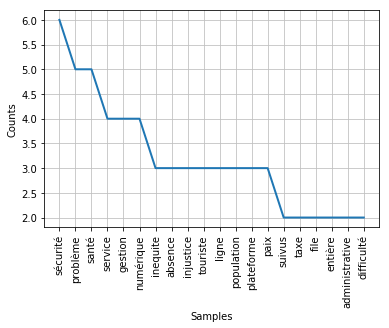

In [8]:
# Afficher les graphques de frequence des mots pour les preocupations exprimées en régions
freq_problemes.plot(20, cumulative=False) # uncomment to see output

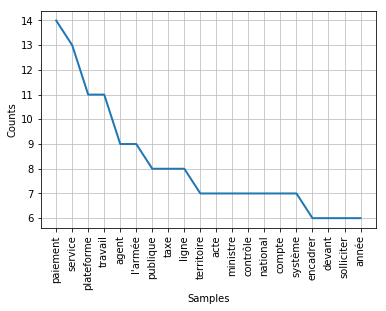

In [9]:
# Afficher les graphques de frequence des mots pour les propositions de solutions en régions
freq_solutions.plot(20, cumulative=False) # uncomment to see output

In [10]:
#########################################################
## 2 - Consultations regionales
########################################################
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

#importation des données de google spreadsheet
data_url = 'https://docs.google.com/spreadsheets/d/1x7FFFmqHeQwEmJx1iaP1zEX_Bh3AglVZZJG9pIwWusc/edit?usp=sharing'
google_credentials = 'cocreation-f23bef2d618c.json'
propositions = read_data(data_url, google_credentials)
# propositions.head(5) # de-commentez cette ligne pour afficher les données et en avoir un apperçu
# Vous pouvez aussi utiliser la ligne ci-dessous en ayant prealablement telecharger les données en format csv sur votre disque local
# propositions = pd.read_csv("consultations_regions.csv")

texte_problemes = " ".join(propositions["probleme"])
texte_solutions = " ".join(propositions["solution"])
texte_domaines2 = "\n".join(propositions["domaine"])



texte_problemes = visual_cleaning(texte_problemes)
texte_solutions = visual_cleaning(texte_solutions)

cleaned_tokens_problemes = clean_tokens(texte_problemes)
cleaned_tokens_solutions = clean_tokens(texte_solutions)

#cráetion du tableau de frequence des mots 
freq_problemes = nltk.FreqDist(cleaned_tokens_problemes)
freq_solutions = nltk.FreqDist(cleaned_tokens_solutions)
# d-commentez les deux ligne ci-dessous pour voir le tableau des frequences
# for key,val in freq.items():
#    print(key.encode('utf-8') + ':' + str(val))

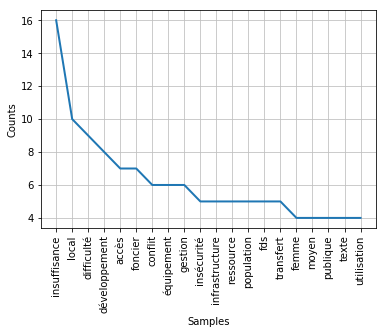

In [11]:
# Afficher les graphques de frequence des mots pour les preocupations exprimées en ligne
freq_problemes.plot(20, cumulative=False) # uncomment to see output

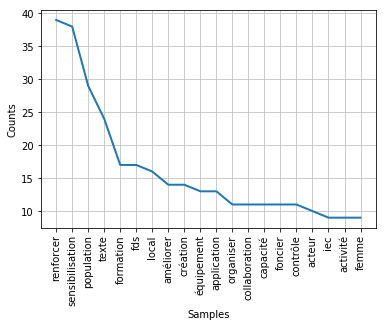

In [12]:
# Afficher les graphques de frequence des mots pour les propositions de solutions faites en ligne
freq_solutions.plot(20, cumulative=False) # uncomment to see output

In [13]:
# Création de nuages de mots sur les consultations en régions
import os
import re
from PIL import Image
from os import path
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
def makeImage(text):
    alice_mask = np.array(Image.open("bf9.jpg"))

    wc = WordCloud(background_color="white", max_words=100, mask=alice_mask)
    # generate word cloud
    wc.generate(text)

    # show
    plt.figure(figsize=(15,15), dpi=100)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    
texte_problemes = " ".join(cleaned_tokens_problemes)
texte_solutions = " ".join(cleaned_tokens_solutions)

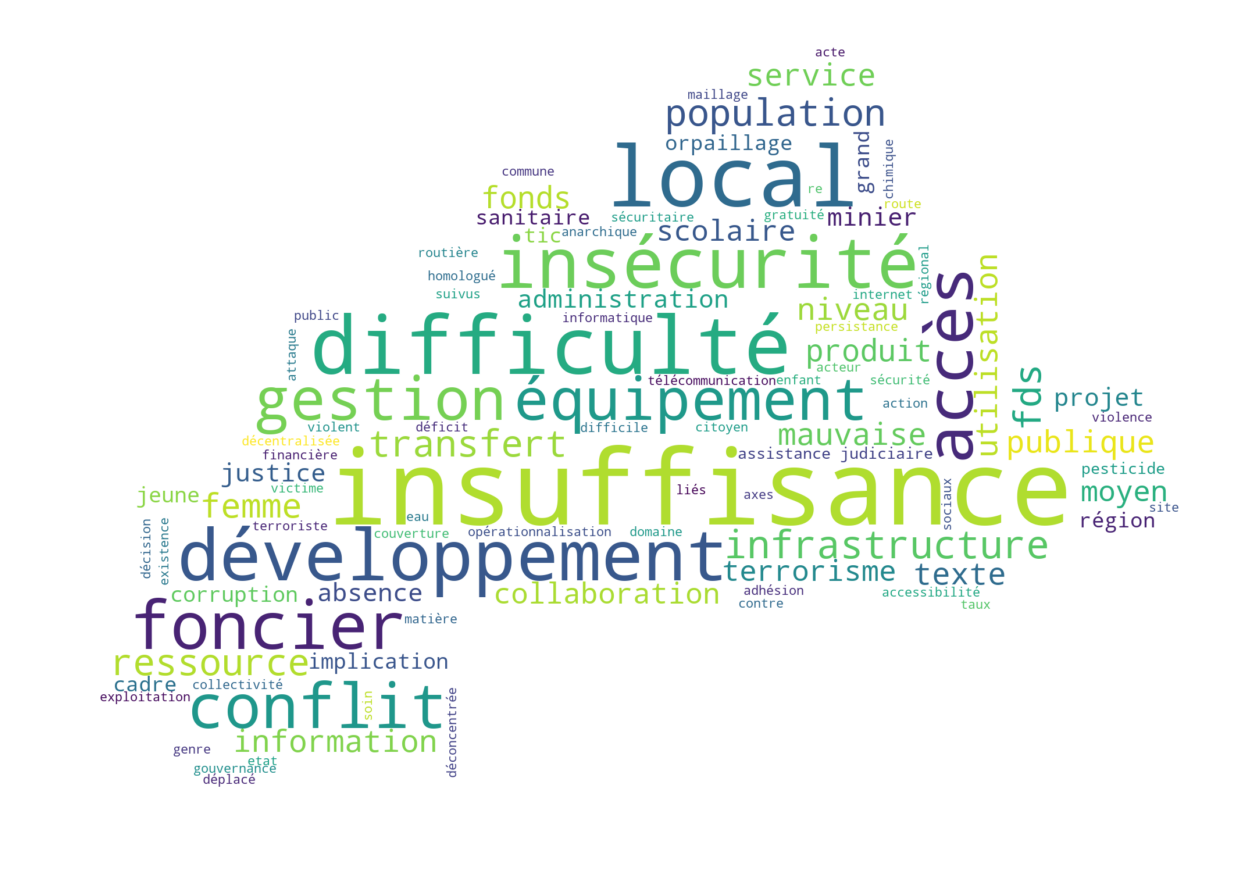

In [14]:
makeImage(texte_problemes.decode("utf-8")) # un-comment to see the wordcloud for problems

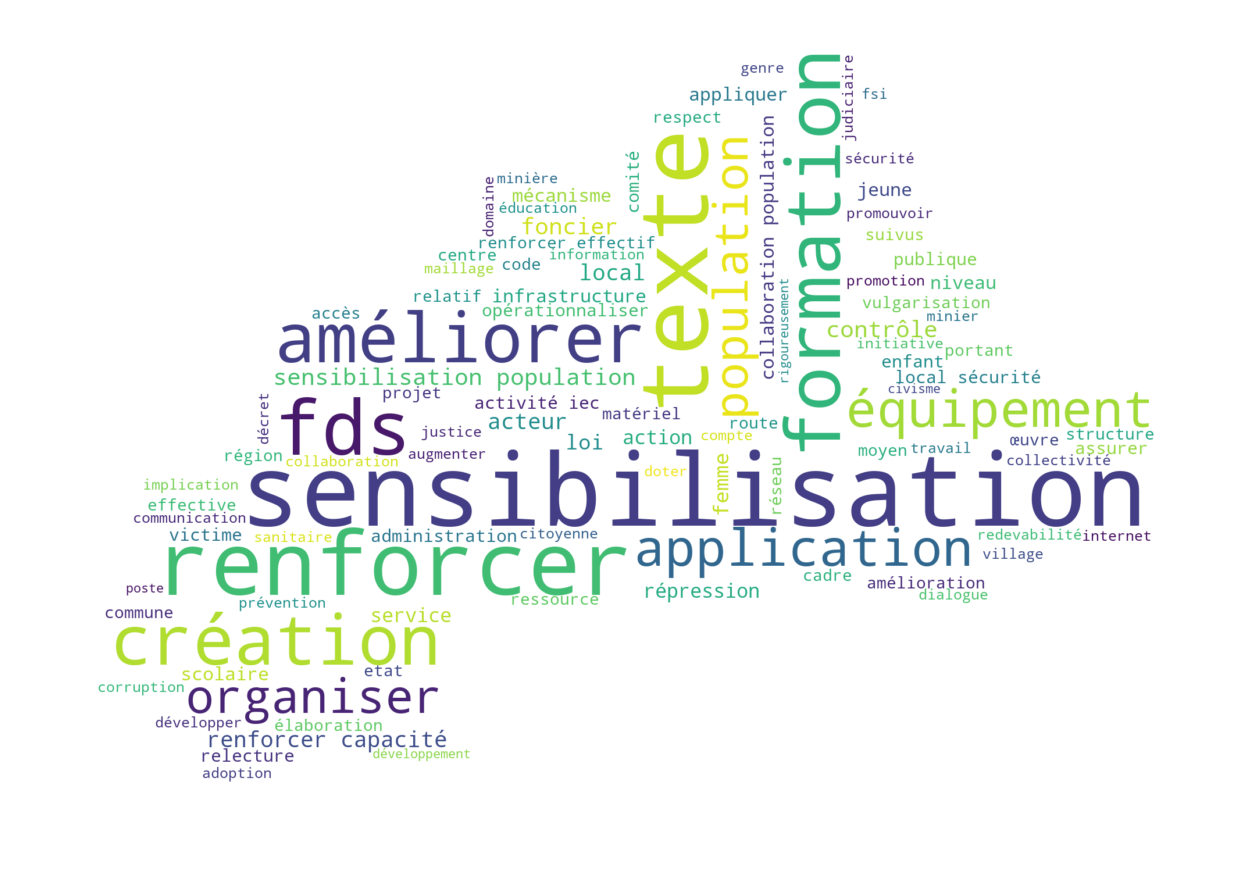

In [15]:
makeImage(texte_solutions.decode("utf-8")) # un-comment to see the wordcloud for solutions

In [16]:
#########################################################
## 3 - Analyse des domaines des preocupations
########################################################
import re
def clean_and_tokenize(texte, t_agg):
    
    # lower texte
    texte = texte.lower()
    
    # each tocken on a line
    texte = texte.encode("utf-8")
    texte = texte.replace(",", "\n")
    texte = texte.replace(";", "\n")
    texte = texte.replace("(", "\n")
    texte = texte.replace(")", "")
    texte = texte.replace("/", "\n")
    texte = texte.replace("l'", "")

    # trim spaces
    texte = re.sub('( )( )*\n', '\n', texte)
    texte = re.sub('\n( )( )*', '\n', texte)
    texte = re.sub('\n(\n)*', '\n', texte)
    texte = re.sub('\nla ', '\n', texte)
    texte = re.sub('\nle ', '\n', texte)
    texte = texte.replace('\nl\u2019', '\n')
    texte = texte.replace('.', '')

    # visual cleaning and tokens agreggation
    for item in t_agg:
        for t in item["rep_texte"]:
            texte = texte.replace(t, item["w"])

    # tokenization
    texte = texte.replace('\n\n', '\n')
    tokens = texte.split("\n")

    return tokens

In [17]:
texte_domaines = texte_domaines1 + "\n" + texte_domaines2

In [18]:
# importing aggregation data
import ast
agg_data = pd.read_csv("https://raw.githubusercontent.com/lingani/Cocreation-PAN2-Burkina-Faso/master/data_aggragation_model.csv")
t_agg = []
for index, item in agg_data.iterrows():
    l = {}
    l["w"] = item["w"]
    l["rep_texte"] = ast.literal_eval(item["rep_texte"])
    t_agg.append(l)

In [19]:
texte_domaines = clean_and_tokenize(texte_domaines, t_agg)

In [20]:
freq_domaines = nltk.FreqDist(texte_domaines)

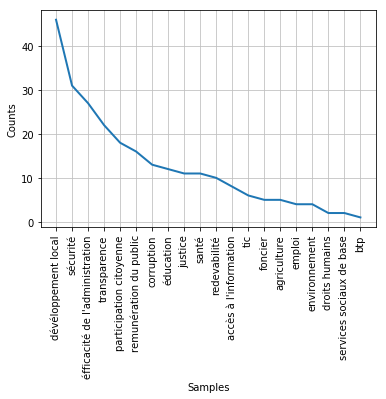

In [21]:
freq_domaines.plot(20, cumulative=False)